## Test

In [5]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import os
import math

from pprint import pprint

from pricing.models.abtests import *
from pricing.utils import convert_numeric
# from src.utils import *
from pprint import pprint
import os


from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

from pricing.operations.experiments import level_1_kind_1_courses_1

print("Using as base_host: ", os.environ["PRICING_API_HOST"])

pd.set_option('display.max_columns', None)
from datetime import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using as base_host:  http://10.2.142.113:3000/


In [154]:
alternative_id = 373 #seasonality lower of exp 56
# alternative_id = 3734 #seasonality lowest of exp 56
# df = load_test_data(spark,alternative_id)
df = load_test_data_v2(spark,alternative_id)
df.head()

,order_id,offer_id,registered_at,fee_experiment_id,alternative,customer_id,checkout_step,price,value,original_value,discount_value,created_at,real_discount,university_id,exchange,coupon_id,origin,alternative_value,baseline_value,alternative_discount
0,9316315,42468841,2020-01-17 16:59:05.548885,56,baseline,408171062,registered,1252.60,1252.60,1252.60,None,2020-01-14 17:06:07.393027,20.00,19,False,NaN,Quero Bolsa,None,1252.60,NaN
1,9344070,42268710,2020-01-16 00:54:40.223380,56,baseline,240323757,registered,563.70,563.70,563.70,None,2020-01-16 00:54:08.607869,0.00,25,False,NaN,Quero Bolsa,422.77,563.70,0.250009
2,9347941,42450923,2020-01-16 12:25:56.287768,56,baseline,371737397,registered,688.32,688.32,688.32,None,2020-01-16 12:25:30.492937,20.00,19,False,NaN,Quero Bolsa,516.24,688.32,0.250000
3,9348663,42743793,2020-01-16 13:07:40.869889,56,baseline,408862871,paid,782.65,782.65,782.65,None,2020-01-16 13:05:54.848120,13.71,1308,False,2264447.0,Quero Bolsa,586.99,782.65,0.249997
4,9349391,42648398,2020-01-16 13:48:50.181306,56,seasonality lower,407810742,commited,963.39,963.39,963.39,None,2020-01-16 13:45:31.269456,34.01,1570,False,2264555.0,Quero Bolsa,963.39,1253.81,0.231630


5272
Theoretical discount:  0.25


,order_id,offer_id,registered_at,fee_experiment_id,alternative,customer_id,checkout_step,price,value,original_value,discount_value,created_at,real_discount,university_id,exchange,coupon_id,origin,alternative_value,baseline_value,alternative_discount
1,9472576,43548753,2020-01-21 22:04:02.032963,58,baseline,381067596,registered,508.17,528.17,528.17,None,2020-01-21 22:03:24.255547,0.00,34,False,NaN,Quero Bolsa,396.13,528.17,0.249995
2,9486543,43083564,2020-01-22 14:19:54.517227,58,baseline,412187657,registered,587.89,587.89,587.89,None,2020-01-22 14:19:13.323473,6.25,163,False,NaN,Quero Bolsa,444.44,587.89,0.244008
3,9488728,43337779,2020-01-22 15:41:04.247215,58,baseline,405639978,registered,297.15,297.15,297.15,None,2020-01-22 15:36:39.682286,23.20,30,False,NaN,Quero Bolsa,222.86,297.15,0.250008
5,9519893,43453414,2020-01-23 20:42:20.434208,58,baseline,411732003,registered,566.08,566.08,566.08,None,2020-01-23 20:39:54.999038,22.88,27,False,NaN,Quero Bolsa,424.56,566.08,0.250000
7,9531014,43992618,2020-01-24 13:48:32.131195,58,baseline,35239760,registered,311.72,311.72,311.72,None,2020-01-24 13:47:47.877655,0.00,29,False,NaN,Quero Bolsa,233.79,311.72,0.250000


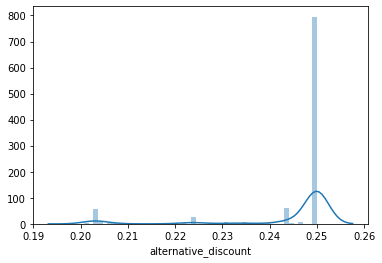

In [129]:
#Cleaning!! 

# print("% of rows lost due to no alternative in the moment of the creating of the order: ", 100*(pd.isna(df['alternative_discount']).value_counts()/df.shape[0])[True])
df= df[pd.isna(df['alternative_discount'])==False]
print(df.shape[0])

#Getting the theorical value of the discount
aux = df['alternative_discount'].value_counts().reset_index()
aux[aux['index']!=0].sort_values('alternative_discount',ascending=False).iloc[0]['index']

#Getting the theorical value of the discount
aux = df['alternative_discount'].value_counts().reset_index()
discount_theory = aux[aux['index']!=0].sort_values('alternative_discount',ascending=False).iloc[0]['index']
print("Theoretical discount: ", discount_theory)

# df_clean = df[math.fabs(df['alternative_discount']-discount_theory) <=0.05]
df_clean = df[ 
    ((df['alternative_discount']-discount_theory) <= 0.05 )&
    ((df['alternative_discount']-discount_theory) >= -0.05)
].copy()
sns.distplot(df_clean['alternative_discount'].astype(float))

df_clean.head()



In [141]:
(df_clean['registered_at'].dt.date.astype(str) =='2020-01-25').value_counts()

False    3801
True      301
Name: registered_at, dtype: int64

In [145]:
df_clean[
    (df_clean['alternative']=='seasonality lower')&\
    (df_clean['registered_at'].dt.date.astype(str) =='2020-01-25')
].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33 entries, 41 to 5206
Data columns (total 21 columns):
order_id                33 non-null int32
offer_id                33 non-null int32
registered_at           33 non-null datetime64[ns]
fee_experiment_id       33 non-null int64
alternative             33 non-null object
customer_id             33 non-null int32
checkout_step           33 non-null object
price                   33 non-null float64
value                   33 non-null object
original_value          33 non-null object
discount_value          4 non-null object
created_at              33 non-null datetime64[ns]
real_discount           33 non-null object
university_id           33 non-null int32
exchange                33 non-null bool
coupon_id               16 non-null float64
origin                  33 non-null object
alternative_value       33 non-null object
baseline_value          33 non-null object
alternative_discount    33 non-null float64
registered_day         

In [146]:
df_cum_results = get_cumulative_agg_results(df_clean)
df_cum_results

,alternative,registered_day,n_visits,n_paids,revenue,price,real_discount,order_id,arpu,registered_conversion,av_ticket
0,baseline,2020-01-21,744,101.0,27899.14,290.434788,15.73,800,37.498844,0.135753,276.229109
1,baseline,2020-01-22,1411,208.0,55096.37,295.140007,15.58,1532,39.047746,0.147413,264.886394
2,baseline,2020-01-23,1982,290.0,78267.87,297.583456,15.61,2170,39.489339,0.146317,269.889207
3,baseline,2020-01-24,2392,340.0,91235.17,297.231229,15.65,2644,38.141793,0.142140,268.338735
4,baseline,2020-01-25,2622,362.0,97438.28,297.090443,15.64,2912,37.161815,0.138063,269.166519
5,baseline,2020-01-26,2847,387.0,104622.87,297.120057,15.66,3160,36.748462,0.135933,270.343333
6,baseline,2020-01-27,3232,420.0,112386.65,296.642994,15.67,3601,34.773097,0.129950,267.587262
7,baseline,2020-01-28,3324,424.0,113194.21,296.950132,15.69,3702,34.053613,0.127557,266.967476
8,seasonality lower,2020-01-21,81,11.0,2157.74,223.521412,15.53,85,26.638765,0.135802,196.158182
9,seasonality lower,2020-01-22,156,25.0,4955.96,219.288902,16.17,164,31.768974,0.160256,198.238400


In [150]:
df = df_clean.copy()
df['registered_day'] = pd.to_datetime(df['registered_at'].dt.date )
df = df.sort_values('registered_day')

df['paid_revenue'] = df.apply(lambda x: x['price'] if (x['checkout_step']=='paid')&(x['exchange']==False) else np.nan ,axis=1)

df['cumsum_paid_revenue'] = df.groupby('alternative')['paid_revenue'].transform(lambda x: x.fillna(0).cumsum())


# df[['cumsum_price','cumsum_rd']] = df.groupby(['alternative'])['price','real_discount'].transform(lambda x: x.cumsum())

# df_agg =  df.groupby(['alternative','registered_day']).agg({
# 'cumsum_new_customer_id': 'last',
# 'cumsum_new_paid_order_id': 'last',
# 'cumsum_paid_revenue':'last',
# 'cumsum_price':'last',
# 'cumsum_rd':'last',
# 'order_id':'count'
# })
df


,order_id,offer_id,registered_at,fee_experiment_id,alternative,customer_id,checkout_step,price,value,original_value,discount_value,created_at,real_discount,university_id,exchange,coupon_id,origin,alternative_value,baseline_value,alternative_discount,registered_day,paid_revenue,cumsum_paid_revenue
1,9472576,43548753,2020-01-21 22:04:02.032963,58,baseline,381067596,registered,508.17,528.17,528.17,None,2020-01-21 22:03:24.255547,0.00,34,False,NaN,Quero Bolsa,396.13,528.17,0.249995,2020-01-21,NaN,0.00
1049,9455043,43151624,2020-01-21 11:41:05.594112,58,baseline,411405203,registered,149.90,252.40,252.40,102.50,2020-01-21 11:38:31.296053,20.37,61,False,NaN,Quero Bolsa,189.30,252.40,0.250000,2020-01-21,NaN,0.00
1050,9469209,43413373,2020-01-21 19:56:05.760972,58,baseline,412324759,registered,324.61,324.61,324.61,None,2020-01-21 19:53:50.769630,24.53,27,False,NaN,Quero Bolsa,243.46,324.61,0.249992,2020-01-21,NaN,0.00
1051,9471884,43160422,2020-01-21 21:37:31.759166,58,baseline,412378673,registered,242.16,242.16,242.16,None,2020-01-21 21:35:27.343956,20.22,24,False,NaN,Quero Bolsa,181.62,242.16,0.250000,2020-01-21,NaN,0.00
1052,9475763,43149697,2020-01-21 23:59:14.771068,58,baseline,2127446,registered,242.16,242.16,242.16,None,2020-01-21 23:58:49.682302,20.22,24,False,NaN,Quero Bolsa,181.62,242.16,0.250000,2020-01-21,NaN,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3758,9581244,53548364,2020-01-28 00:54:40.688873,58,baseline,144965793,registered,200.34,200.34,200.34,None,2020-01-28 00:47:17.536470,19.88,61,False,NaN,Quero Bolsa,150.25,200.34,0.250025,2020-01-28,NaN,112922.02
3803,9580481,42689921,2020-01-28 00:13:06.288372,58,baseline,1466450,registered,188.06,188.06,188.06,None,2020-01-28 00:11:50.916100,6.67,74,False,NaN,Quero Bolsa,149.90,188.06,0.202914,2020-01-28,NaN,112922.02
3839,9582127,43095263,2020-01-28 01:35:01.369446,58,baseline,339014773,commited,587.89,587.89,587.89,None,2020-01-28 01:33:43.220330,6.25,163,False,2305514.0,Quero Bolsa,444.44,587.89,0.244008,2020-01-28,NaN,112922.02
3896,9581565,53541220,2020-01-28 01:04:06.566459,58,baseline,405040822,paid,272.19,272.19,272.19,None,2020-01-28 01:02:43.641714,31.24,61,False,2305454.0,Quero Bolsa,204.14,272.19,0.250009,2020-01-28,272.19,113194.21


In [153]:
df[
    (df['alternative']=='baseline')&
    (df['registered_day']<='2020-01-25')
]['paid_revenue'].sum()

97438.28

In [151]:
df[
    (df['alternative']=='baseline')&
    (df['registered_day']=='2020-01-25')
]

,order_id,offer_id,registered_at,fee_experiment_id,alternative,customer_id,checkout_step,price,value,original_value,discount_value,created_at,real_discount,university_id,exchange,coupon_id,origin,alternative_value,baseline_value,alternative_discount,registered_day,paid_revenue,cumsum_paid_revenue
617,9548607,46889613,2020-01-25 15:17:44.274489,58,baseline,310522798,registered,232.40,232.40,232.40,None,2020-01-25 15:15:27.276399,27.44,61,False,NaN,Quero Bolsa,174.30,232.40,0.250000,2020-01-25,NaN,91235.17
112,9546964,44088663,2020-01-25 13:00:35.875308,58,baseline,409692076,commited,251.91,251.91,251.91,None,2020-01-25 12:56:49.781728,10.00,19,False,2298875.0,Quero Bolsa,188.93,251.91,0.250010,2020-01-25,NaN,91235.17
4559,9549104,44246321,2020-01-25 16:04:06.233419,58,baseline,250241655,commited,279.54,279.54,279.54,None,2020-01-25 16:03:34.264006,20.00,19,False,2299311.0,Quero Bolsa,209.66,279.54,0.249982,2020-01-25,NaN,91235.17
4629,9543236,43986623,2020-01-25 00:15:07.742300,58,baseline,368466200,paid,545.78,545.78,545.78,None,2020-01-25 00:14:27.591828,0.00,52,False,2298343.0,Quero Bolsa,409.34,545.78,0.249991,2020-01-25,545.78,91780.95
4141,9543944,44244318,2020-01-25 01:11:27.890380,58,baseline,407659121,commited,298.83,298.83,298.83,None,2020-01-25 01:06:43.222948,20.00,19,False,2298387.0,Quero Bolsa,224.12,298.83,0.250008,2020-01-25,NaN,91780.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
716,9552291,44007616,2020-01-25 22:12:44.903043,58,baseline,372337154,registered,327.03,327.03,327.03,None,2020-01-25 22:12:11.223991,0.00,1638,False,NaN,Quero Bolsa,245.27,327.03,0.250008,2020-01-25,NaN,97438.28
1008,9543371,43404049,2020-01-25 01:59:41.563467,58,baseline,413058389,registered,379.03,379.03,379.03,None,2020-01-25 00:23:39.996839,28.91,67,False,NaN,Quero Bolsa,284.27,379.03,0.250007,2020-01-25,NaN,97438.28
3754,9547602,44104752,2020-01-25 13:57:29.161940,58,baseline,413926857,commited,260.26,260.26,260.26,None,2020-01-25 13:54:39.152653,20.00,19,False,2299009.0,Quero Bolsa,195.19,260.26,0.250019,2020-01-25,NaN,97438.28
3126,9547951,44098198,2020-01-25 14:24:04.488992,58,baseline,410131820,registered,260.26,260.26,260.26,None,2020-01-25 14:23:46.035282,20.00,19,False,NaN,Quero Bolsa,195.19,260.26,0.250019,2020-01-25,NaN,97438.28


In [130]:
# df_cum_results = get_cumulative_agg_results(df)
df_cum_results = get_cumulative_agg_results(df_clean)
# hist_data = {
#     'conversion':{
#         'mean': .07,
#         'std': .2
#     },
#     'aov':{
#         'mean': 500,
#         'std':100
#     }
# }
hist_data = None
abtest = BayesianABTest('arpu',df['alternative'].unique().tolist(), hist_data = hist_data)


Initiating ABTests with priors:
{'baseline': {'lambda': {'alpha': 1, 'beta': 1}, 'theta': {'k': 1, 'omega': 1}},
 'seasonality lower': {'lambda': {'alpha': 1, 'beta': 1},
                       'theta': {'k': 1, 'omega': 1}}}


In [131]:
#Feeding data to the test
for alternative in df_clean['alternative'].unique().tolist():
    
    last_data = df_cum_results.groupby('alternative').agg('last').reset_index()

    n_visits = last_data[last_data['alternative']==alternative]['n_visits'].values[0]
    n_paids = last_data[last_data['alternative']==alternative]['n_paids'].values[0]
    revenue = last_data[last_data['alternative']==alternative]['revenue'].values[0]
    arpu = last_data[last_data['alternative']==alternative]['arpu'].values[0]


    print("\nData for alternative :" , alternative)
    print("n_visits: ", n_visits,"\nn_paids: ", n_paids, "\nrevenue: ",revenue, "arpu: ",arpu)
  
    
    abtest.feed_alternative_data(
        alternative,
        n_visits=n_visits,
        n_paids=n_paids,
        revenue = revenue
    )



Data for alternative : baseline
n_visits:  3324 
n_paids:  424.0 
revenue:  113194.20999999983 arpu:  34.05361311672679

Data for alternative : seasonality lower
n_visits:  374 
n_paids:  45.0 
revenue:  9125.49 arpu:  24.39970588235294


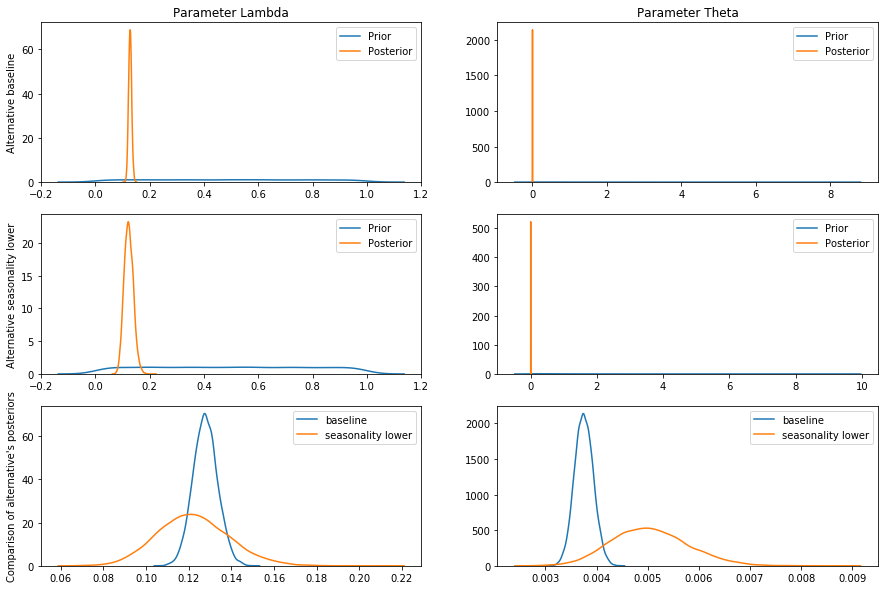

In [132]:
abtest.plot_parameter_distributions()

In [133]:
df_cum_results

,alternative,registered_day,n_visits,n_paids,revenue,price,real_discount,order_id,arpu,registered_conversion,av_ticket
0,baseline,2020-01-21,744,101.0,27899.14,290.434788,15.73,800,37.498844,0.135753,276.229109
1,baseline,2020-01-22,1411,208.0,55096.37,295.140007,15.58,1532,39.047746,0.147413,264.886394
2,baseline,2020-01-23,1982,290.0,78267.87,297.583456,15.61,2170,39.489339,0.146317,269.889207
3,baseline,2020-01-24,2392,340.0,91235.17,297.231229,15.65,2644,38.141793,0.142140,268.338735
4,baseline,2020-01-25,2622,362.0,97438.28,297.090443,15.64,2912,37.161815,0.138063,269.166519
5,baseline,2020-01-26,2847,387.0,104622.87,297.120057,15.66,3160,36.748462,0.135933,270.343333
6,baseline,2020-01-27,3232,420.0,112386.65,296.642994,15.67,3601,34.773097,0.129950,267.587262
7,baseline,2020-01-28,3324,424.0,113194.21,296.950132,15.69,3702,34.053613,0.127557,266.967476
8,seasonality lower,2020-01-21,81,11.0,2157.74,223.521412,15.53,85,26.638765,0.135802,196.158182
9,seasonality lower,2020-01-22,156,25.0,4955.96,219.288902,16.17,164,31.768974,0.160256,198.238400


In [135]:
df_compare = df_cum_results.pivot(index='registered_day', columns='alternative', values=['n_visits', 'n_paids','registered_conversion','av_ticket','price','real_discount', 'revenue','arpu'])
df_compare['ticket_decrease'] = 1-df_compare[('av_ticket','seasonality lower')]/df_compare[('av_ticket','baseline')]
# df_compare['price_discount'] = 1- df_cum_results_price['seasonality lower']/df_cum_results_price['baseline']
df_compare

n_visits                    n_paids                    \
alternative    baseline seasonality lower baseline seasonality lower   
registered_day                                                         
2020-01-21        744.0              81.0    101.0              11.0   
2020-01-22       1411.0             156.0    208.0              25.0   
2020-01-23       1982.0             213.0    290.0              32.0   
2020-01-24       2392.0             266.0    340.0              39.0   
2020-01-25       2622.0             296.0    362.0              39.0   
2020-01-26       2847.0             313.0    387.0              40.0   
2020-01-27       3232.0             365.0    420.0              44.0   
2020-01-28       3324.0             374.0    424.0              45.0   

               registered_conversion                     av_ticket  \
alternative                 baseline seasonality lower    baseline   
registered_day                                                       
2020-01-21                  0.135753          0.135802  276.229109   
2020-01-22                  0.147413          0.160256  264.886394   
2020-01-23                  0.146317          0.150235  269.889207   
2020-01-24                  0.142140          0.146617  268.338735   
2020-01-25                  0.138063          0.131757  269.166519   
2020-01-26                  0.135933          0.127796  270.343333   
2020-01-27                  0.129950          0.120548  267.587262   
2020-01-28                  0.127557          0.120321  266.967476   

                                       price                   real_discount  \
alternative    seasonality lower    baseline seasonality lower      baseline   
registered_day                                                                 
2020-01-21            196.158182  290.434788        223.521412         15.73   
2020-01-22            198.238400  295.140007        219.288902         15.58   
2020-01-23            205.468125  297.583456        224.061333         15.61   
2020-01-24            205.105128  297.231229        223.593607         15.65   
2020-01-25                   NaN  297.090443        222.936550         15.64   
2020-01-26            206.102500  297.120057        224.226495         15.66   
2020-01-27            203.618636  296.642994        224.204499         15.67   
2020-01-28            202.788667  296.950132        223.583125         15.69   

                                    revenue                         arpu  \
alternative    seasonality lower   baseline seasonality lower   baseline   
registered_day                                                             
2020-01-21                 15.53   27899.14           2157.74  37.498844   
2020-01-22                 16.17   55096.37           4955.96  39.047746   
2020-01-23                 15.63   78267.87           6574.98  39.489339   
2020-01-24                 15.29   91235.17           7999.10  38.141793   
2020-01-25                 15.38   97438.28               NaN  37.161815   
2020-01-26                 15.32  104622.87           8244.10  36.748462   
2020-01-27                 15.73  112386.65           8959.22  34.773097   
2020-01-28                 15.71  113194.21           9125.49  34.053613   

                                 ticket_decrease  
alternative    seasonality lower                  
registered_day                                    
2020-01-21             26.638765        0.289871  
2020-01-22             31.768974        0.251610  
2020-01-23             30.868451        0.238695  
2020-01-24             30.071805        0.235648  
2020-01-25                   NaN             NaN  
2020-01-26             26.338978        0.237627  
2020-01-27             24.545808        0.239057  
2020-01-28             24.399706        0.240399

/home/pricing/src/pricing/models/abtests/bayesian_test.py:142: RuntimeWarning: invalid value encountered in greater
  'prob2beat': (smp['lambdaB']/smp['thetaB'] > smp['lambdaA']/smp['thetaA']).sum()/self.n_samples,
/home/pricing/src/pricing/models/abtests/bayesian_test.py:145: RuntimeWarning: invalid value encountered in greater
  'expLift': py_round((lift*(lift>0)).mean(),2),
/home/pricing/src/pricing/models/abtests/bayesian_test.py:146: RuntimeWarning: invalid value encountered in greater
  'expPercLift': (perc_lift*(perc_lift>0)).mean(),
/home/pricing/src/pricing/models/abtests/bayesian_test.py:147: RuntimeWarning: invalid value encountered in greater
  'expLoss': py_round((-lift*(-lift>0)).mean(),2),
/home/pricing/src/pricing/models/abtests/bayesian_test.py:148: RuntimeWarning: invalid value encountered in greater
  'expPercLoss': (-perc_lift*(-perc_lift>0)).mean(),


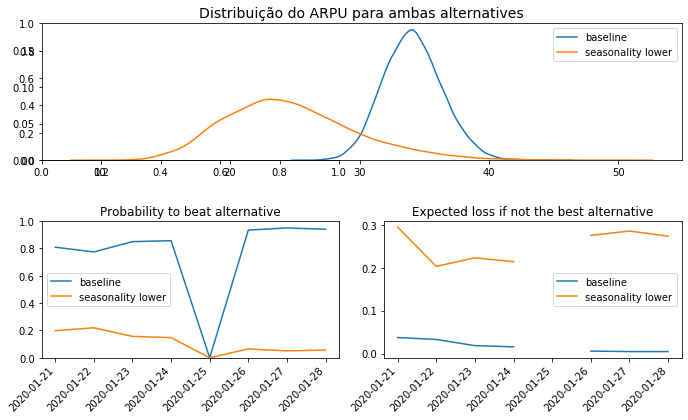

In [136]:
fig, axs = plt.subplots(2,2,figsize=(10,6))
gs = axs[0,0].get_gridspec()
# remove the underlying axes
for ax in axs[0,1:]:
    ax.remove()
axbig = fig.add_subplot(gs[0,0:])

fig.tight_layout()

abtest.plot_results(axbig)
abtest.plot_cumulative_results(df_cum_results,ax=axs[1])

plt.tight_layout()
plt.show()


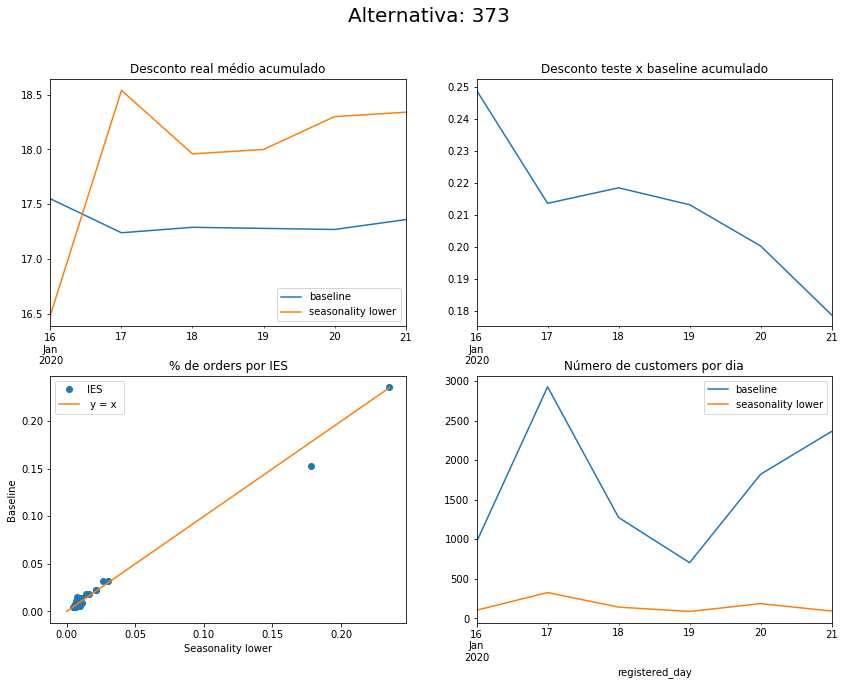

None

In [117]:
fig,ax= plt.subplots(2,2,figsize=(14,10))


for alternative in df_cum_results['alternative'].unique().tolist():
    df_cum_results[df_cum_results['alternative'] == alternative].set_index('registered_day')['real_discount'].plot(ax=ax[0][0],label = alternative)
ax[0][0].set_title("Desconto real médio acumulado")
ax[0][0].set_xlabel("")
ax[0][0].legend()

#Avg accumulated price 
df_cum_results_price = df_cum_results.reset_index().pivot(index='registered_day',columns = 'alternative',values='price')
df_cum_results_price['price_discount'] = 1- df_cum_results_price['seasonality lower']/df_cum_results_price['baseline']
df_cum_results_price['price_discount'].plot(ax=ax[0][1],title = "Desconto teste x baseline acumulado")
ax[0][1].set_xlabel("")

#Distribution of orders per university
df_cum_results_uni = df_clean.groupby('alternative')['university_id'].apply(lambda x: (x.value_counts()/x.shape[0]).iloc[:30]).reset_index()
df_cum_results_uni = df_cum_results_uni.pivot(index='level_1',columns = 'alternative',values = 'university_id').sort_values('baseline',ascending=False)
ax[1][0].plot(df_cum_results_uni['baseline'], df_cum_results_uni['seasonality lower'],'o',label = 'IES' )
ax[1][0].set_title("% de orders por IES")
ax[1][0].set_ylabel("Baseline")
ax[1][0].set_xlabel("Seasonality lower")
ax[1][0].plot([0,df_cum_results_uni['baseline'].max()],[0,df_cum_results_uni['baseline'].max()],label =' y = x ')
ax[1][0].legend()

#Numbers of unique customers per day
df_customers = df_clean.groupby(['registered_day','alternative'])['customer_id'].nunique().reset_index().set_index('registered_day')
for alternative in df_customers['alternative'].unique().tolist():
    df_customers[df_customers['alternative'] == alternative]['customer_id'].plot(ax=ax[1][1],label = alternative)
ax[1][1].set_title("Número de customers por dia")
ax[1][1].legend()

fig.suptitle("Alternativa: " + str(alternative_id),fontsize = 20)
plt.legend()
# plt.tight_layout()
display(plt.show())




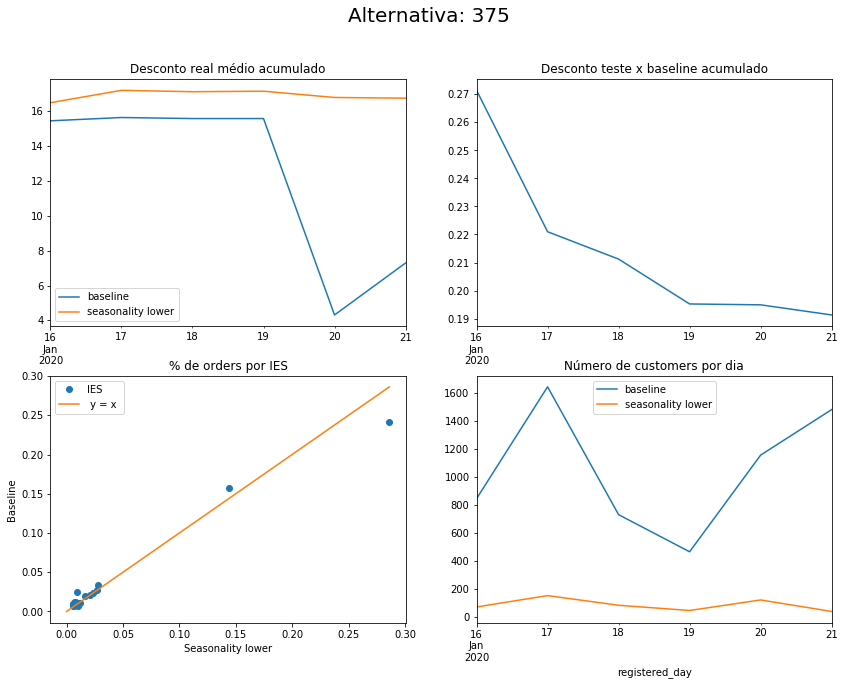

None

In [127]:
fig,ax= plt.subplots(2,2,figsize=(14,10))


for alternative in df_cum_results['alternative'].unique().tolist():
    df_cum_results[df_cum_results['alternative'] == alternative].set_index('registered_day')['real_discount'].plot(ax=ax[0][0],label = alternative)
ax[0][0].set_title("Desconto real médio acumulado")
ax[0][0].set_xlabel("")
ax[0][0].legend()

#Avg accumulated price 
df_cum_results_price = df_cum_results.reset_index().pivot(index='registered_day',columns = 'alternative',values='price')
df_cum_results_price['price_discount'] = 1- df_cum_results_price['seasonality lower']/df_cum_results_price['baseline']
df_cum_results_price['price_discount'].plot(ax=ax[0][1],title = "Desconto teste x baseline acumulado")
ax[0][1].set_xlabel("")

#Distribution of orders per university
df_cum_results_uni = df_clean.groupby('alternative')['university_id'].apply(lambda x: (x.value_counts()/x.shape[0]).iloc[:30]).reset_index()
df_cum_results_uni = df_cum_results_uni.pivot(index='level_1',columns = 'alternative',values = 'university_id').sort_values('baseline',ascending=False)
ax[1][0].plot(df_cum_results_uni['baseline'], df_cum_results_uni['seasonality lower'],'o',label = 'IES' )
ax[1][0].set_title("% de orders por IES")
ax[1][0].set_ylabel("Baseline")
ax[1][0].set_xlabel("Seasonality lower")
ax[1][0].plot([0,df_cum_results_uni['baseline'].max()],[0,df_cum_results_uni['baseline'].max()],label =' y = x ')
ax[1][0].legend()

#Numbers of unique customers per day
df_customers = df_clean.groupby(['registered_day','alternative'])['customer_id'].nunique().reset_index().set_index('registered_day')
for alternative in df_customers['alternative'].unique().tolist():
    df_customers[df_customers['alternative'] == alternative]['customer_id'].plot(ax=ax[1][1],label = alternative)
ax[1][1].set_title("Número de customers por dia")
ax[1][1].legend()

fig.suptitle("Alternativa: " + str(alternative_id),fontsize = 20)
plt.legend()
# plt.tight_layout()
display(plt.show())


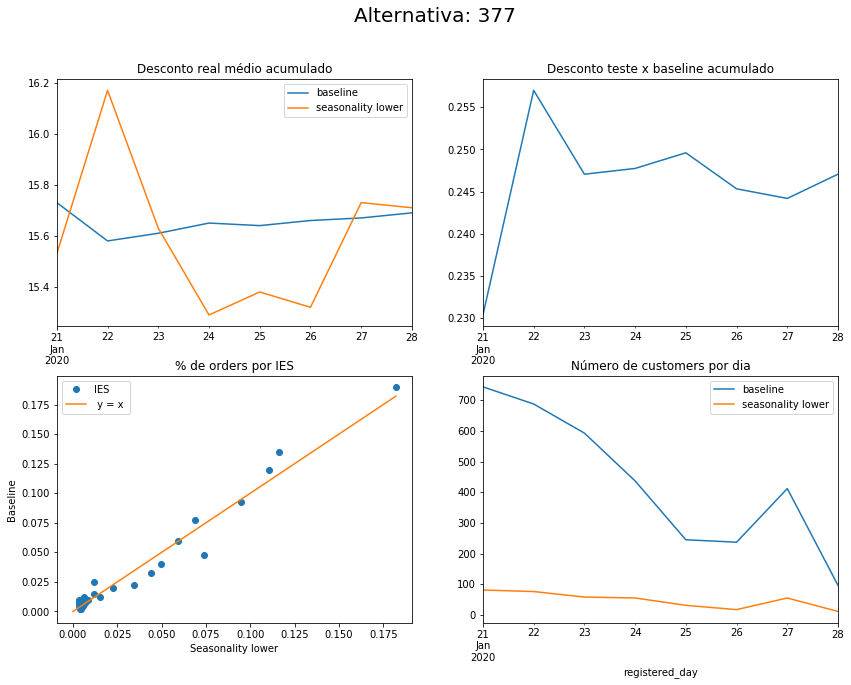

None

In [137]:
fig,ax= plt.subplots(2,2,figsize=(14,10))


for alternative in df_cum_results['alternative'].unique().tolist():
    df_cum_results[df_cum_results['alternative'] == alternative].set_index('registered_day')['real_discount'].plot(ax=ax[0][0],label = alternative)
ax[0][0].set_title("Desconto real médio acumulado")
ax[0][0].set_xlabel("")
ax[0][0].legend()

#Avg accumulated price 
df_cum_results_price = df_cum_results.reset_index().pivot(index='registered_day',columns = 'alternative',values='price')
df_cum_results_price['price_discount'] = 1- df_cum_results_price['seasonality lower']/df_cum_results_price['baseline']
df_cum_results_price['price_discount'].plot(ax=ax[0][1],title = "Desconto teste x baseline acumulado")
ax[0][1].set_xlabel("")

#Distribution of orders per university
df_cum_results_uni = df_clean.groupby('alternative')['university_id'].apply(lambda x: (x.value_counts()/x.shape[0]).iloc[:30]).reset_index()
df_cum_results_uni = df_cum_results_uni.pivot(index='level_1',columns = 'alternative',values = 'university_id').sort_values('baseline',ascending=False)
ax[1][0].plot(df_cum_results_uni['baseline'], df_cum_results_uni['seasonality lower'],'o',label = 'IES' )
ax[1][0].set_title("% de orders por IES")
ax[1][0].set_ylabel("Baseline")
ax[1][0].set_xlabel("Seasonality lower")
ax[1][0].plot([0,df_cum_results_uni['baseline'].max()],[0,df_cum_results_uni['baseline'].max()],label =' y = x ')
ax[1][0].legend()

#Numbers of unique customers per day
df_customers = df_clean.groupby(['registered_day','alternative'])['customer_id'].nunique().reset_index().set_index('registered_day')
for alternative in df_customers['alternative'].unique().tolist():
    df_customers[df_customers['alternative'] == alternative]['customer_id'].plot(ax=ax[1][1],label = alternative)
ax[1][1].set_title("Número de customers por dia")
ax[1][1].legend()

fig.suptitle("Alternativa: " + str(alternative_id),fontsize = 20)
plt.legend()
# plt.tight_layout()
display(plt.show())
